# Analyse d'images : localisation de points brillants

Ce chapitre explore différentes stratégies pour localiser les points les plus brillants d'une image. Ces techniques sont essentielles pour le traitement d'images en microscopic, astronomie et vision par ordinateur.

---

## Stratégies de localisation

- **Maximum global** : trouver le pixel le plus brillant (rapide mais peu robuste)
- **Centre de masse pondéré** : calculer le barycentre des intensités (plus robuste)
- **Ajustement gaussien** : modéliser la distribution des intensités comme gaussienne
- **Seuillage** : isoler les régions brillantes et trouver leur centre
- **Ajustement de cercle** : adapter un cercle aux régions détectées

In [2]:
# Importation des bibliothèques
import imageio as iio
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

# Charger une image en niveaux de gris (moyenne des canaux RGB)
data = np.average(iio.imread('data/sun.jpg'), axis=-1)
# Alternative : data = np.average(iio.imread('moon.png'), axis=-1)

print('Dimensions de l\'image:', data.shape)
print('Gamme de valeurs:', np.min(data), 'à', np.max(data))

Dimensions de l'image: (638, 850)
Gamme de valeurs: 19.666666666666668 à 253.0


/tmp/ipykernel_2743798/1930382418.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  data = np.average(iio.imread('data/sun.jpg'), axis=-1)


---

## Méthode 1 : maximum global

Trouver le pixel avec l'intensité maximale. C'est la méthode la plus simple mais peu robuste face au bruit.

`np.argmax()` retourne l'index du maximum dans un tableau aplati. `np.unravel_index()` le convertit en coordonnées 2D.

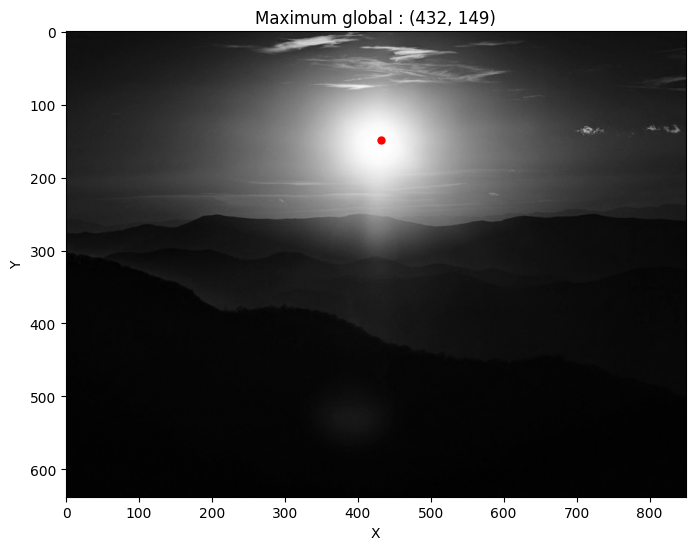

Position du maximum : x=432, y=149
Intensité maximale : 253.00


In [3]:
# Trouver le pixel avec la plus haute intensité
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(data, cmap='gray')

# argmax retourne l'index du maximum dans le tableau aplati
max_index = data.argmax()
# unravel_index convertit l'index 1D en coordonnées 2D (x, y)
x, y = np.unravel_index(max_index, data.shape)

# Marquer le point trouvé sur l'image
ax.plot([y], [x], marker='o', markersize=5, color='red')
ax.set_title(f"Maximum global : ({y}, {x})")
ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

print(f"Position du maximum : x={y}, y={x}")
print(f"Intensité maximale : {data[x, y]:.2f}")

---

## Méthode 2 : centre de masse pondéré

Calculer le barycentre en utilisant les intensités comme poids. Cela donne une meilleure localisation que le maximum global, en particulier pour les distributions étendues.

`np.average()` avec le paramètre `weights` calcule la moyenne pondérée.

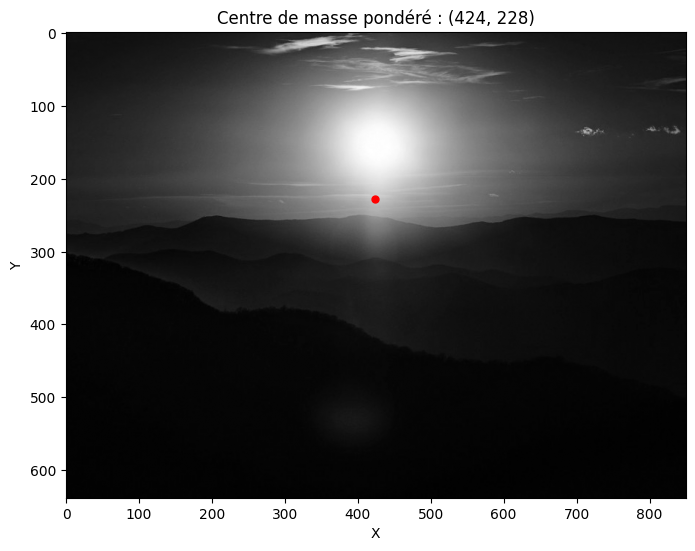

Position du centre de masse : x=424, y=228
Intensité au centre : 197.67


In [4]:
# Calculer le centre de masse pondéré par les intensités
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(data, cmap='gray')

# Normaliser l'image entre 0 et 1 pour les poids
data_normalized = data.copy() / np.max(data)

# Obtenir toutes les coordonnées (x, y)
positions = np.where(data)

# Calculer la moyenne pondérée des positions
# weights utilise les intensités pour pondérer le calcul
x_center = int(np.average(positions[0], weights=data[positions]))
y_center = int(np.average(positions[1], weights=data[positions]))

ax.plot([y_center], [x_center], marker='o', markersize=5, color='red')
ax.set_title(f"Centre de masse pondéré : ({y_center}, {x_center})")
ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

print(f"Position du centre de masse : x={y_center}, y={x_center}")
print(f"Intensité au centre : {data[x_center, y_center]:.2f}")

---

## Méthode 3 : ajustement gaussien

Modéliser les profils d'intensité selon les axes X et Y comme des distributions gaussiennes. Cela permet d'estimer le centre avec sub-pixel accuracy.

Pour chaque axe, on calcule la somme des intensités et on ajuste une gaussienne.

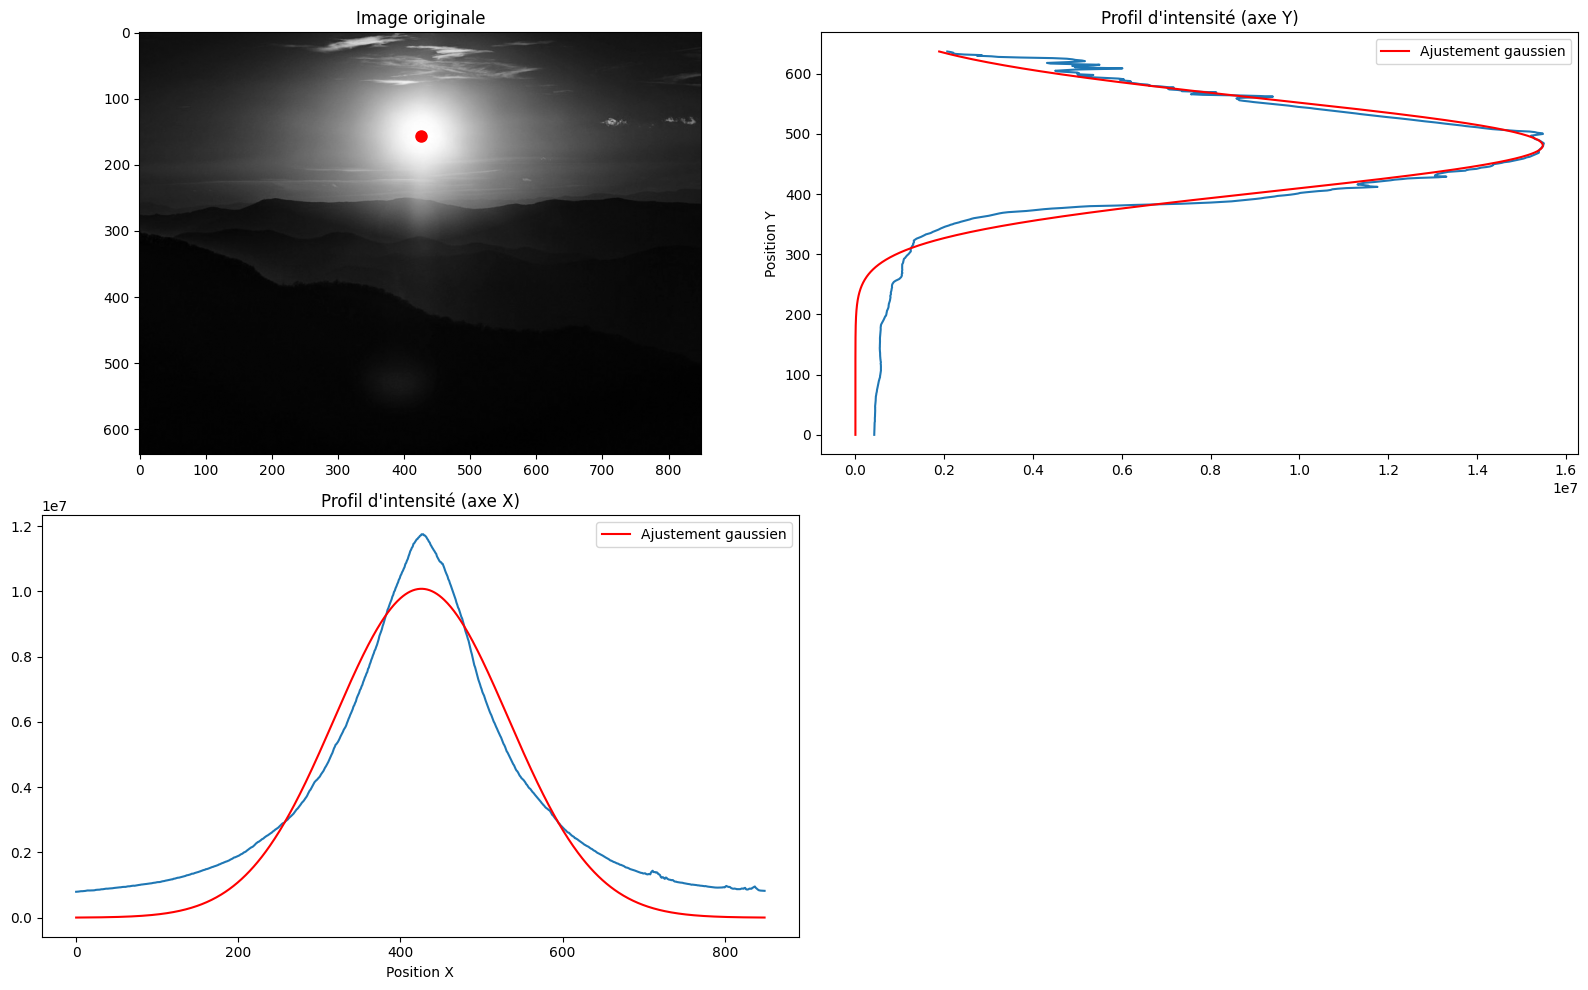

Position par ajustement gaussien : x=425, y=156


In [5]:
# Définir la fonction gaussienne à ajuster
def gaussian(x, *p):
    # Paramètres : amplitude A, centre mu, écart-type sigma
    A, mu, sigma = p
    return A * np.exp(-(x - mu)**2 / (2.0 * sigma**2))

# Convertir l'image en float pour les calculs
data_float = data.astype(float)

# Créer une figure avec 4 sous-graphiques
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Afficher l'image originale
im = axs[0, 0].imshow(data_float, cmap='gray')
axs[0, 0].set_title("Image originale")

# Analyse selon l'axe Y (sommation sur les colonnes)
x_axis = np.arange(data.shape[0])
# Calculer la somme des intensités au carré pour chaque ligne
intensity_y = np.sum(data_float**2, axis=1)

axs[0, 1].plot(intensity_y, x_axis[::-1])
axs[0, 1].set_title("Profil d'intensité (axe Y)")
axs[0, 1].set_ylabel("Position Y")

# Ajuster une gaussienne au profil Y
coeff_y, _ = optimize.curve_fit(gaussian, x_axis, intensity_y, p0=[1.0, 0.0, 1.0])
axs[0, 1].plot(gaussian(x_axis, *coeff_y), x_axis[::-1], 'r-', label='Ajustement gaussien')
axs[0, 1].legend()

# Analyse selon l'axe X (sommation sur les lignes)
y_axis = np.arange(data.shape[1])
# Calculer la somme des intensités au carré pour chaque colonne
intensity_x = np.sum(data_float**2, axis=0)

axs[1, 0].plot(y_axis, intensity_x)
axs[1, 0].set_title("Profil d'intensité (axe X)")
axs[1, 0].set_xlabel("Position X")

# Ajuster une gaussienne au profil X
coeff_x, _ = optimize.curve_fit(gaussian, y_axis, intensity_x, p0=[1.0, 0.0, 1.0])
axs[1, 0].plot(y_axis, gaussian(y_axis, *coeff_x), 'r-', label='Ajustement gaussien')
axs[1, 0].legend()

# Extraire les paramètres d'ajustement
x_center_gaussian = int(coeff_x[1])  # Centre selon X
y_center_gaussian = int(coeff_y[1])  # Centre selon Y

# Marquer le centre sur l'image
axs[0, 0].plot([x_center_gaussian], [y_center_gaussian], marker='o', markersize=8, color='red')
axs[1, 1].axis('off')

fig.tight_layout()
plt.show()

print(f"Position par ajustement gaussien : x={x_center_gaussian}, y={y_center_gaussian}")

---

## Méthode 4 : seuillage simple

Appliquer un seuil pour isoler les pixels brillants, puis calculer le centre de masse de la région masquée. C'est rapide et efficace si la région brillante est bien définie.

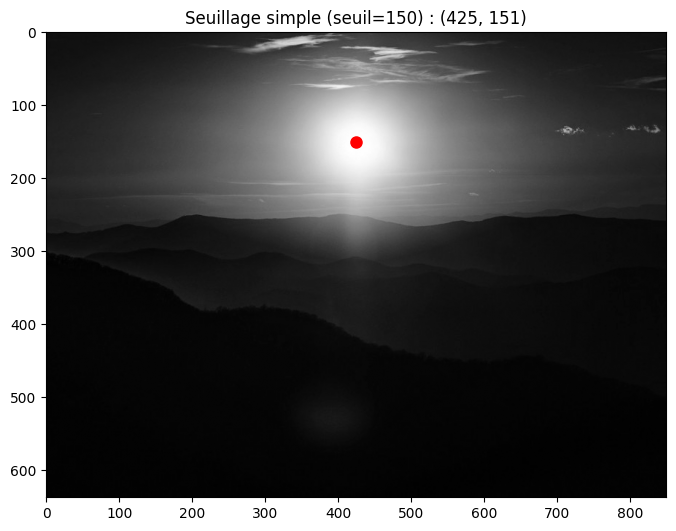

Position par seuillage : x=425, y=151
Nombre de pixels au-dessus du seuil : 38763


In [6]:
# Seuillage simple : garder seulement les pixels très brillants
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(data, cmap='gray')

# Créer un masque des pixels au-dessus d'un seuil (150)
threshold = 150
data_masked = data.copy()
data_masked[data < threshold] = 0

# Obtenir les coordonnées des pixels au-dessus du seuil
positions = np.argwhere(data_masked)

# Calculer le centre de masse du masque
x_center_threshold = int(np.average(positions[:, 0]))
y_center_threshold = int(np.average(positions[:, 1]))

ax.plot([y_center_threshold], [x_center_threshold], marker='o', markersize=8, color='red')
ax.set_title(f"Seuillage simple (seuil={threshold}) : ({y_center_threshold}, {x_center_threshold})")

plt.show()

print(f"Position par seuillage : x={y_center_threshold}, y={x_center_threshold}")
print(f"Nombre de pixels au-dessus du seuil : {len(positions)}")

---

## Résumé des méthodes

| Méthode | Vitesse | Robustesse | Précision |
|---------|---------|-----------|-----------|
| Maximum global | Très rapide | Faible | Pixel complet |
| Centre de masse | Rapide | Moyenne | Sub-pixel |
| Ajustement gaussien | Moyenne | Bonne | Sub-pixel |
| Seuillage | Rapide | Bonne | Pixel complet |

Le choix de la méthode dépend de vos données et de vos exigences de précision.

Prochain chapitre : `g_inspect_dataset.ipynb`